In [1]:
# this notebook looks at the total gold
# of players and teams

# this is different to networth
# which is the current networth of a player
# is a player sells items and uses consumables
# then their networth will decrease

# however, total gold = current gold + gold spent
# is monotonic so should be a better indicator
# of a team members contribution.

# for example supports could have very low networth
# because they buy regen/wards
# but would have a higher total gold

In [2]:
import json
import numpy as np
import glob
import matplotlib.pyplot as plt

In [41]:
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("seaborn-ticks")
plt.rcParams.update({'font.size':16})

In [4]:
with open("match_data/WEU/6299231379.json") as f:
    data = json.load(f)

In [5]:
data['data'].keys()

dict_keys(['channels', 'derived_series', 'dire', 'duration', 'has_error', 'league', 'match_id', 'patch', 'radiant', 'radiant_victory', 'rating_shifts', 'replay_info', 'start_date', 'state'])

In [6]:
data['data']['duration']

2071

In [7]:
# minutes
data['data']['duration'] // 60

34

In [8]:
# seconds
data['data']['duration'] % 60

31

In [9]:
# note you can't just do
data['data']['duration']/60
# this is wrong... for some reason

34.516666666666666

In [10]:
# seconds
# 2071 - (34 * 60) = 31

In [11]:
data['data']['duration'] - (data['data']['duration']//60 * 60)

31

In [12]:
data['data']['start_date']

1638280518000

In [13]:
data['data']['radiant_victory']

False

In [14]:
data['data']['dire'].keys()

dict_keys(['player_performances', 'team'])

In [15]:
len(data['data']['dire']['player_performances'])

5

In [16]:
data['data']['dire']['player_performances'][0].keys()

dict_keys(['laneInfo', 'performance', 'player'])

In [17]:
data['data']['dire']['player_performances'][0]['performance'].keys()

dict_keys(['abilities', 'assists', 'building_damage', 'deaths', 'end_game_gold', 'gold_spent', 'gpm', 'hero', 'hero_damage', 'hero_healing', 'items', 'kills', 'laneInfo', 'level', 'xpm'])

In [18]:
data['data']['dire']['player_performances'][0]['performance']['end_game_gold']

3098

In [19]:
data['data']['dire']['player_performances'][-1]['performance']['hero']

{'short_name': 'snapfire', 'valve_id': 128}

In [20]:
[p['performance']['end_game_gold']+p['performance']['gold_spent'] for p in data['data']['dire']['player_performances']]

[19773, 13744, 16085, 28942, 15036]

In [21]:
np.sum([p['performance']['end_game_gold'] for p in data['data']['dire']['player_performances']])

10585

In [22]:
np.sum([p['performance']['gold_spent'] for p in data['data']['dire']['player_performances']])

82995

In [23]:
10585+82995

93580

In [24]:
[p['performance']['end_game_gold']+p['performance']['gold_spent'] for p in data['data']['radiant']['player_performances']]

[7422, 7396, 15131, 14772, 14548]

In [25]:
[p['performance']['hero'] for p in data['data']['radiant']['player_performances']]



[{'short_name': 'tusk', 'valve_id': 100},
 {'short_name': 'lion', 'valve_id': 26},
 {'short_name': 'nevermore', 'valve_id': 11},
 {'short_name': 'skeletonking', 'valve_id': 42},
 {'short_name': 'mars', 'valve_id': 129}]

In [26]:
[p['performance']['end_game_gold']+p['performance']['gold_spent'] for p in data['data']['dire']['player_performances']]

[19773, 13744, 16085, 28942, 15036]

In [27]:
15036/60

250.6

In [28]:
15036/34.31

438.23958029728936

In [29]:
13.8e3/34.52

399.7682502896871

In [30]:
[p['performance']['hero'] for p in data['data']['dire']['player_performances']]



[{'short_name': 'facelessvoid', 'valve_id': 41},
 {'short_name': 'gyrocopter', 'valve_id': 72},
 {'short_name': 'earthspirit', 'valve_id': 107},
 {'short_name': 'doombringer', 'valve_id': 69},
 {'short_name': 'snapfire', 'valve_id': 128}]

# function to get total gold and winning team from match csv

In [31]:
def get_data(filename):
    with open(filename) as f:
        data = json.load(f)
        
    radiant_win = data['data']['radiant_victory']
    
    dire_total_gold = np.sum([p['performance']['end_game_gold']+p['performance']['gold_spent'] for p in data['data']['dire']['player_performances']])
    radiant_total_gold = np.sum([p['performance']['end_game_gold']+p['performance']['gold_spent'] for p in data['data']['radiant']['player_performances']])
    
    gold_diff = radiant_total_gold - dire_total_gold
    
    duration = data['data']['duration']
    
    duration_min, duration_sec = duration // 60, duration % 60
    
    return {"radiant_win":radiant_win, "gold_diff":gold_diff, 'duration':duration, 'duration_min':duration_min, 'duration_sec':duration_sec}

In [32]:
get_data(filename="match_data/WEU/6299231379.json")

{'radiant_win': False,
 'gold_diff': -34311,
 'duration': 2071,
 'duration_min': 34,
 'duration_sec': 31}

In [33]:
filenames = glob.glob("match_data/*/*")

In [34]:
results = [get_data(filename=filename) for filename in filenames]

In [35]:
radiant_win = np.array([result['radiant_win'] for result in results])
radiant_win_bin = radiant_win*1

# radiant_win_bin = 0 for false
# radiant_win_bin = 1 for true

gold_diff = np.array([result['gold_diff'] for result in results])

duration_min = np.array([result['duration_min'] for result in results])

In [36]:
plt.figure(figsize=(6,4))
plt.hist(duration_min, bins=10);
plt.xlabel("duration [min]")

Text(0.5, 0, 'duration [min]')

In [37]:
radiant_win_bin

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1])

In [38]:
gold_diff

array([-18917,  14814,  19208, -44480, -34561, -28914, -24612, -13257,
       -31430,  19519, -40213,  23285, -48787,  26680,  26575, -30818,
        33522,  12653,  11281, -25992, -34697,  29311, -18420, -32195,
        26806,  23153,  22211,  19501, -33553,  23031,  37441, -21134,
        22999,  33924, -35526, -17363, -38173, -56194, -34311,  -9078,
        26066,  11421,   9475, -26793, -20755,  10013,  23802, -23595,
       -40194,  44372,  23331, -25867, -22494,  21526,  18256, -24870,
        13596,  13908, -20552,  23984,  26861,   9207,  25848,  34571,
        25106,  29519, -24395,  17305, -21448,  30638,  23220,  31741,
       -33932,  24865, -27692, -17607, -30225, -22446, -22339,  15480,
        28959, -19229, -26269,  30820, -32469, -18777, -15017, -25839,
        30508,  31876])

In [39]:
plt.figure(figsize=(8,4))
plt.scatter(gold_diff, radiant_win_bin)
plt.xlabel("gold difference at end of game")
plt.ylabel("radiant win")

Text(0, 0.5, 'radiant win')

In [40]:
n_games = len(radiant_win_bin)
n_rad_win = (radiant_win_bin==1).sum()
n_dire_win = (radiant_win_bin==0).sum()

print(n_games)
print(n_rad_win)
print(n_dire_win)

print(n_rad_win/n_games * 100)
print(n_dire_win/n_games * 100)

90
46
44
51.11111111111111
48.888888888888886


# Bayesian Inference - probability for radiant to win (coin toss)

In [78]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)
    # one_minus_p = pm.Deterministic(name='notp', var=1-p)
    y = pm.Bernoulli('y', p=p, observed=radiant_win_bin)

In [79]:
model

In [80]:
%%time
with model:
    trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:02<00:00, 10025.39draws/s]
The acceptance probability does not match the target. It is 0.8892688333146495, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 1.36 s, sys: 169 ms, total: 1.53 s
Wall time: 9.16 s


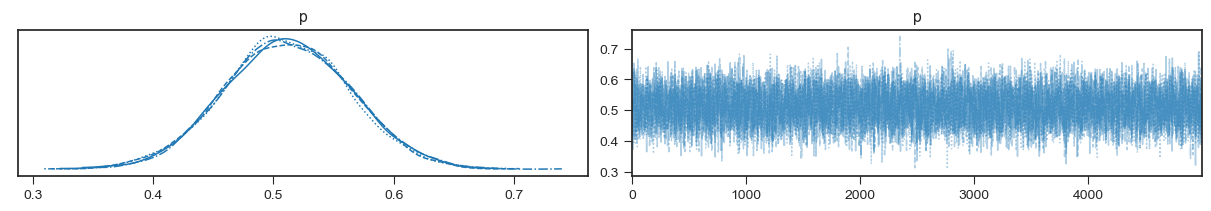

In [81]:
with model:
    az.plot_trace(trace)
    plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


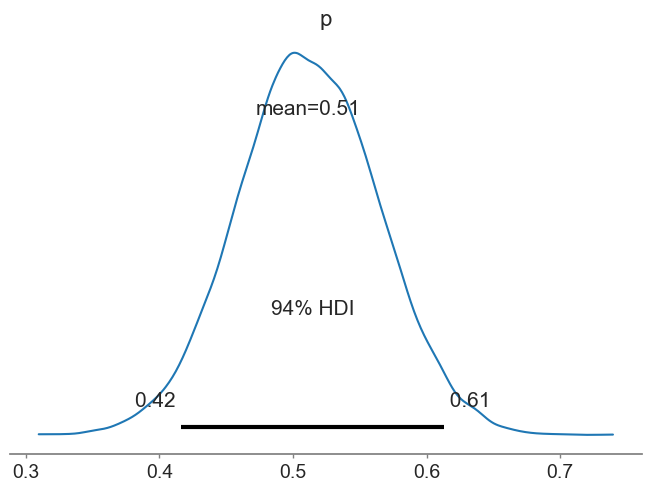

In [82]:
az.plot_posterior(trace)
plt.show()

In [83]:
az.summary(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
p  0.511  0.052   0.417    0.613      0.001      0.0    7951.0  7951.0   

   ess_bulk  ess_tail  r_hat  
p    7960.0   13730.0    1.0

# Bayesian logistic regression model using Wins as the outcome

In [ ]:
# based on the paper: "A Bayesian adjusted plus-minus analysis for the esport Dota 2"
# by Nicholas Clark*, Brian Macdonald and Ian Kloo

# in their paper they were on the player level and I will try on the team level